# Workshop 7 - Autoencoders

In lecture 18 we have talked about autoencoders and their applications. In this last workshop we will have some fun with a non-biomedical task, and create an autoencoder to colorize images.

Remember the generic idea of an autoencoder?

<div>
<img src="Autoencoder_schema.png" width="50%" />
</div>

We have an encoding part that _compresses_ the input into a bottleneck layer (the **latent space**) and then we have a decoding part that _decompresses_ the latent space into the original input.

The trick to using autoencoders for tasks like denoising or colorization is to train them on pairs of noisy/non-noisy or non-colorized/colorized images, exploiting the fact that the latent space only contains the **important** information needed to reconstruct the input.

## Learning objectives

At the end of this workshop, you will be able to:

- Create a simple autoencoder
- Use it to colorize black-and-white images


We start by importing the usual libraries

In [1]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

2022-06-24 11:34:28.982003: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-24 11:34:29.101291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 11:34:29.101323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First of all we need some images!
We can use the CIFAR-100 dataset, which contains images (32x32 RGB) of 100 classes (600/class). We won't need the labels for this, so we'll just load the images.

In [3]:
from skimage.color import rgb2gray

# This downloads ~160MB
# These images are colour images, so they will be our OUTPUTS
(y_train, _), (y_test, _) = keras.datasets.cifar100.load_data()
# We convert the images to grayscale and use them as inputs

x_train = np.array([rgb2gray(x) for x in y_train])
x_test = np.array([rgb2gray(x) for x in y_test])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32) (50000, 32, 32, 3)
(10000, 32, 32) (10000, 32, 32, 3)


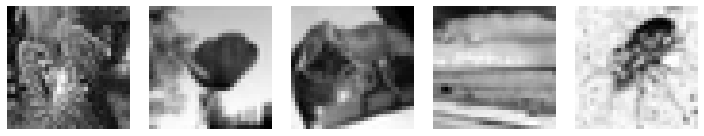

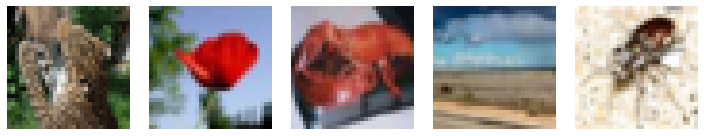

In [3]:
# Plot a few images to check everything is working

ids = np.random.randint(0, len(x_train), size=16)

fig, ax = plt.subplots(1, 5, figsize=(10, 2))

for i, a in enumerate(ax):
    a.imshow(x_train[ids[i]], cmap='gray')
    a.axis('off')

plt.tight_layout()

fig, ax = plt.subplots(1, 5, figsize=(10, 2))

for i, a in enumerate(ax):
    a.imshow(y_train[ids[i]])
    a.axis('off')

plt.tight_layout()

OK, now use the knowledge from the lectures to create a simple autoencoder. You can start with a simple architecture using Conv2D and MaxPooling2D and UpSampling2D layers. You can experiment with different architectures (number of layers, filter size etc) or, for instance, add a dense layer to create the latent space.

In [4]:
model = keras.Sequential()

# ENCODER
model.add(keras.layers.InputLayer(input_shape=(32, 32, 1)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# LATENT SPACE
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

# DECODER
model.add(keras.layers.UpSampling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
# Output an RGB image
model.add(keras.layers.UpSampling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(keras.layers.Conv2D(3, (3, 3), activation='relu', padding="same"))

model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0

And now... training time!

In [5]:
batch_size = x_train.shape[0]//50 # 50 passes/epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=batch_size)

model.save("Autoencoder_colouring")

Epoch 1/100
 3/50 [>.............................] - ETA: 7:58 - loss: 19289.2656

KeyboardInterrupt: 

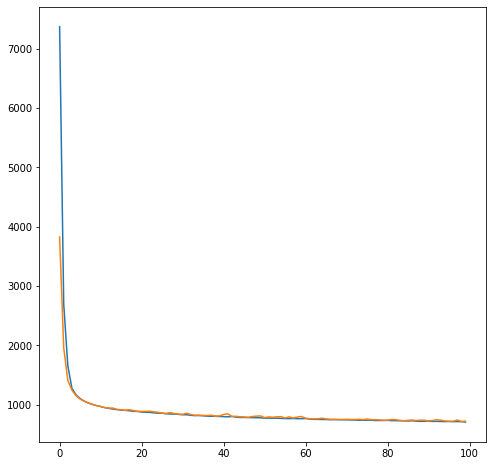

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(history.history['loss'], label="Loss")
ax.plot(history.history['val_loss'], label="Validation loss")

In [8]:
model = keras.models.load_model("Autoencoder_colouring")

OSError: ignored

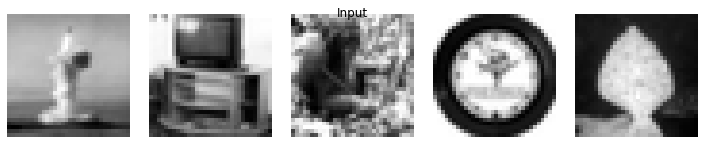

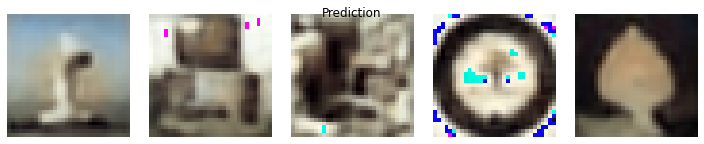

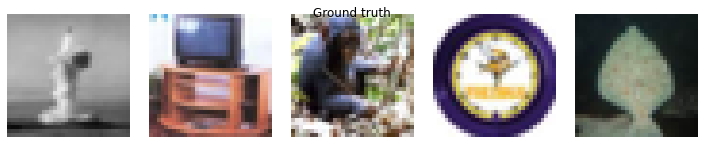

In [ ]:
ids = np.random.randint(0, x_test.shape[0], 5)

fig, ax = plt.subplots(1, 5, figsize = (10, 2))
for i, a in enumerate(ax):
    a.imshow(x_test[ids[i]], cmap="gray")
    a.axis("off")
fig.suptitle("Input")
plt.show()

fig, ax = plt.subplots(1, 5, figsize = (10, 2))

for i, a in enumerate(ax):    
    pred = model.predict(x_test[ids[i]].reshape(1, 32, 32))
    pred = pred.astype(np.uint8)    
    a.imshow(pred[0])
    a.axis("off")    
fig.suptitle("Prediction")
plt.show()

fig, ax = plt.subplots(1, 5, figsize = (10, 2))
for i, a in enumerate(ax):    
    a.imshow(y_test[ids[i]])
    a.axis("off")
fig.suptitle("Ground truth")
plt.show()

**Compare your prediction with the ground truth. What can you observe? Can you think of why this happens?**

As a challenge, you might try to find some solution to the problem.